In [1]:
# Imports y configuración de paths
import os, sys, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed', 'mortalidad')
BASE_OUT = os.path.join(PROJ_ROOT, 'modelos', 'outputs')
NOTEBOOK_NAME = os.path.splitext(os.path.basename(os.environ.get('NOTEBOOK_BASENAME', 'b_08_ml.ipynb')))[0]
OUT_DIR = os.path.join(BASE_OUT, 'output', NOTEBOOK_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

print(f'Datos: {DATA_PATH}')
print(f'Salidas: {OUT_DIR}')

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 60)
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (10,5)

Datos: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/data/processed/mortalidad
Salidas: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml


In [2]:
# Instalar/Importar TensorFlow si es necesario
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, optimizers
    print('TensorFlow:', tf.__version__)
except Exception as e:
    import subprocess, sys as _sys
    print('Instalando TensorFlow ...')
    subprocess.check_call([_sys.executable, '-m', 'pip', 'install', '-q', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, optimizers
    print('TensorFlow:', tf.__version__)

TensorFlow: 2.17.0


In [3]:
# Estilo corporativo (viz.style)
for candidate in ('src', '../src', '../../src', '../../../src'):
    p = os.path.abspath(candidate)
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)
try:
    import importlib, viz.style as _vstyle
    importlib.reload(_vstyle)
except Exception:
    pass
from viz.style import apply_matplotlib_style, get_palette, get_sequential_cmap
apply_matplotlib_style(n_colors=7, base_font_size=11, seaborn_style='white', background='white', transparent=False)
print('Estilo aplicado.')

Estilo aplicado.


In [4]:
# Carga de datos y matriz edad×año (m y log(m))
EPS = 1e-12
file_long = os.path.join(DATA_PATH, 'tasas_mortalidad_gret_per.csv')
df_long = pd.read_csv(file_long).rename(columns={'ano':'year','gr_et':'age'})
df_long_m = df_long[['year','age','tasa_x100k']].copy()
df_long_m['m'] = (df_long_m['tasa_x100k'] / 1e5).clip(lower=EPS)
mat = df_long_m.pivot(index='age', columns='year', values='m').sort_index()
ages = mat.index.values.astype(int)
years = mat.columns.values.astype(int)
mat_log = np.log(mat.clip(lower=EPS))
print('Matriz m:', mat.shape, '| años', years.min(), '-', years.max(), '| edades', ages.min(), '-', ages.max())
mat.head()

Matriz m: (17, 45) | años 1979 - 2023 | edades 1 - 17


year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000049,0.000042,0.000044,0.000039,0.000028,0.000022,0.000024,0.000018,0.000015,0.000014,0.000011,0.000010,0.000009,0.000009,0.000008,0.000006,0.000006,0.000005,0.000004,0.000006,0.000006,0.000006,0.000005,8.499482e-06,0.000007,6.534167e-06,0.000006,7.710106e-06,0.000005,8.390200e-06,0.000006,0.000003,3.653421e-06,3.153650e-06,5.815563e-06,2.921598e-06,2.398540e-06,2.666065e-06,2.392366e-06,3.153282e-06,3.668709e-06,0.000002,3.129253e-06,4.469724e-06,0.000003
2,0.000012,0.000011,0.000013,0.000010,0.000006,0.000009,0.000009,0.000007,0.000007,0.000005,0.000003,0.000004,0.000004,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,0.000002,0.000003,2.798329e-06,0.000002,7.009429e-07,0.000003,1.657103e-06,0.000002,1.449898e-06,0.000002,0.000002,1.249956e-06,2.527166e-07,5.106775e-07,7.732517e-07,1.559143e-06,5.224731e-07,2.617115e-07,4.921904e-07,7.389123e-07,0.000001,4.932269e-07,2.482730e-07,0.000002
3,0.000009,0.000006,0.000010,0.000009,0.000006,0.000007,0.000004,0.000005,0.000003,0.000005,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,7.387396e-07,0.000003,9.613654e-07,0.000002,9.458863e-07,0.000002,9.408289e-07,0.000002,0.000002,7.141590e-07,4.802836e-07,4.853084e-07,9.816835e-07,7.445327e-07,1.002307e-06,1.515173e-06,1.401163e-06,1.396822e-06,0.000001,9.338040e-07,1.178135e-06,0.000001
4,0.000015,0.000013,0.000017,0.000014,0.000012,0.000014,0.000015,0.000008,0.000011,0.000011,0.000008,0.000006,0.000008,0.000008,0.000007,0.000007,0.000006,0.000009,0.000005,0.000006,0.000006,0.000006,0.000006,7.621104e-06,0.000005,3.371316e-06,0.000003,4.305802e-06,0.000005,4.929344e-06,0.000003,0.000003,3.584486e-06,2.853929e-06,3.324185e-06,2.852953e-06,2.863328e-06,4.075270e-06,2.891899e-06,3.997186e-06,3.474033e-06,0.000004,4.770033e-06,5.670935e-06,0.000005
5,0.000034,0.000038,0.000032,0.000031,0.000027,0.000026,0.000019,0.000019,0.000023,0.000018,0.000015,0.000014,0.000014,0.000014,0.000013,0.000016,0.000013,0.000012,0.000011,0.000012,0.000012,0.000011,0.000012,1.439396e-05,0.000011,1.262662e-05,0.000008,8.655184e-06,0.000009,1.042390e-05,0.000010,0.000005,7.747502e-06,6.875696e-06,5.778954e-06,8.438986e-06,5.401696e-06,6.803984e-06,5.055585e-06,7.018536e-06,7.070214e-06,0.000007,1.016314e-05,1.279901e-05,0.000011


In [5]:
# Construcción de secuencias y split temporal
T = 10  # ventanas de historial
cut_year = 2018
idx_cut = int(np.where(years == cut_year)[0][0])
# Normalización (solo con train) en escala log
train_logs = mat_log.iloc[:, :idx_cut+1].values.reshape(-1)
mu, sigma = float(np.mean(train_logs)), float(np.std(train_logs) + 1e-8)

# Generar secuencias train para todas las edades
X_list, y_list, meta_age, meta_year = [], [], [], []
for age in ages:
    s = mat_log.loc[age].values
    for t in range(T, idx_cut+1):  # predice años <= 2018
        X_list.append((s[t-T:t] - mu)/sigma)
        y_list.append((s[t] - mu)/sigma)
        meta_age.append(int(age))
        meta_year.append(int(years[t]))
X_train = np.array(X_list, dtype=np.float32)[..., np.newaxis]  # (N,T,1)
y_train = np.array(y_list, dtype=np.float32)[..., np.newaxis]  # (N,1)
print('Secuencias train:', X_train.shape, y_train.shape)

Secuencias train: (510, 10, 1) (510, 1)


In [6]:
# Definición y entrenamiento del modelo CNN (Conv1D)
from tensorflow.keras import layers, models, callbacks, optimizers

model = models.Sequential([
    layers.Input(shape=(T, 1)),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

opt = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='mse')

es = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=200, batch_size=32, verbose=0, callbacks=[es])

print('Entrenamiento completado. Épocas:', len(hist.history['loss']))

Entrenamiento completado. Épocas: 60


In [7]:
# Predicciones one-step para train (1979–2018)
yhat_train_scaled = model.predict(X_train, verbose=0).reshape(-1)
yhat_train_log = (yhat_train_scaled * sigma) + mu
ytrue_train_log = np.array([mat_log.loc[a, y] for a, y in zip(meta_age, meta_year)])
m_train_pred = np.exp(yhat_train_log)
m_train_obs = np.exp(ytrue_train_log)
train_df = pd.DataFrame({'age': meta_age, 'year': meta_year, 'm_obs': m_train_obs, 'm_pred': m_train_pred})
print('Predicciones train:', train_df.shape)

Predicciones train: (510, 4)


In [8]:
# Predicciones recursivas para validación (2019–2023)
val_years = years[idx_cut+1:]
Xv_meta_age, Xv_meta_year, yhat_val_log = [], [], []
for age in ages:
    s = mat_log.loc[age].values.copy()
    context = s[idx_cut+1-T:idx_cut+1].copy()  # últimos T hasta 2018
    for yy in val_years:
        xin = ((context - mu)/sigma).astype('float32').reshape(1, T, 1)
        y_scaled = float(model.predict(xin, verbose=0).reshape(-1)[0])
        y_log = y_scaled * sigma + mu
        yhat_val_log.append(y_log)
        Xv_meta_age.append(int(age)); Xv_meta_year.append(int(yy))
        context = np.concatenate([context[1:], [y_log]])

m_val_pred = np.exp(np.array(yhat_val_log))
m_val_obs = np.array([mat.loc[a, y] for a, y in zip(Xv_meta_age, Xv_meta_year)])
val_df = pd.DataFrame({'age': Xv_meta_age, 'year': Xv_meta_year, 'm_obs': m_val_obs, 'm_pred': m_val_pred})
print('Predicciones validación:', val_df.shape)

Predicciones validación: (85, 4)


In [9]:
# Métricas (m y log)
from sklearn.metrics import mean_squared_error, mean_absolute_error

def smape(y_true, y_pred, eps=1e-12):
    return 100 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def wape(y_true, y_pred, eps=1e-12):
    return 100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps))

# Train
RMSE_train = float(np.sqrt(mean_squared_error(train_df['m_obs'], train_df['m_pred'])))
MAE_train = float(mean_absolute_error(train_df['m_obs'], train_df['m_pred']))
sMAPE_train = float(smape(train_df['m_obs'], train_df['m_pred']))
WAPE_train = float(wape(train_df['m_obs'], train_df['m_pred']))
RMSE_log_train = float(np.sqrt(mean_squared_error(np.log(train_df['m_obs'].clip(lower=EPS)), yhat_train_log)))

# Val
RMSE_val = float(np.sqrt(mean_squared_error(val_df['m_obs'], val_df['m_pred'])))
MAE_val = float(mean_absolute_error(val_df['m_obs'], val_df['m_pred']))
sMAPE_val = float(smape(val_df['m_obs'], val_df['m_pred']))
WAPE_val = float(wape(val_df['m_obs'], val_df['m_pred']))
RMSE_log_val = float(np.sqrt(mean_squared_error(np.log(val_df['m_obs'].clip(lower=EPS)), np.array(yhat_val_log))))

print('Métricas (escala original por persona):')
print(f'- Train | RMSE: {RMSE_train:.4e} | MAE: {MAE_train:.4e} | sMAPE: {sMAPE_train:.2f}% | WAPE: {WAPE_train:.2f}%')
print(f'- Val   | RMSE: {RMSE_val:.4e} | MAE: {MAE_val:.4e} | sMAPE: {sMAPE_val:.2f}% | WAPE: {WAPE_val:.2f}%')
print('Métricas (escala log):')
print(f'- Train | RMSE_log: {RMSE_log_train:.4e}')
print(f'- Val   | RMSE_log: {RMSE_log_val:.4e}')

Métricas (escala original por persona):
- Train | RMSE: 2.0109e-05 | MAE: 1.0396e-05 | sMAPE: 19.51% | WAPE: 14.77%
- Val   | RMSE: 1.4906e-05 | MAE: 9.6325e-06 | sMAPE: 41.63% | WAPE: 22.63%
Métricas (escala log):
- Train | RMSE_log: 2.7074e-01
- Val   | RMSE_log: 5.1994e-01


dtype pred full: [dtype('float64')]


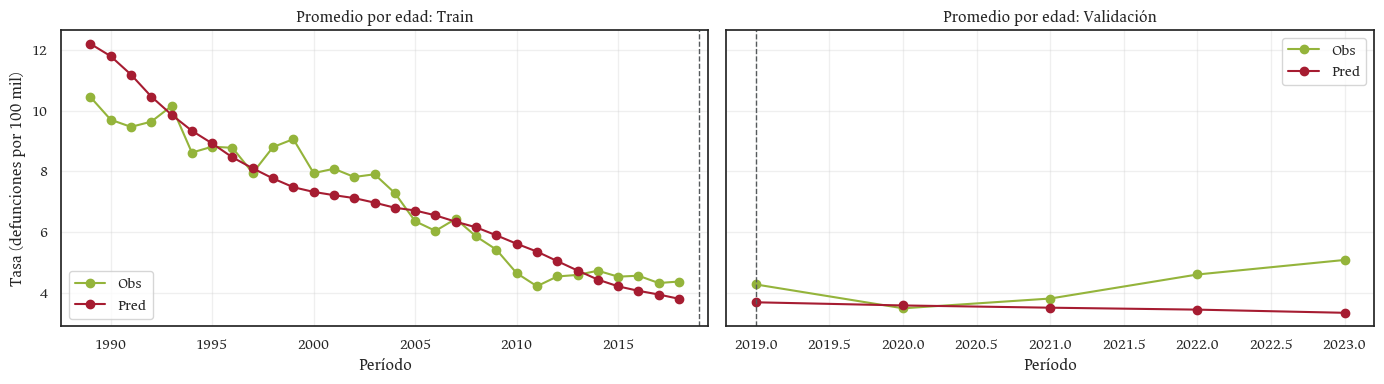

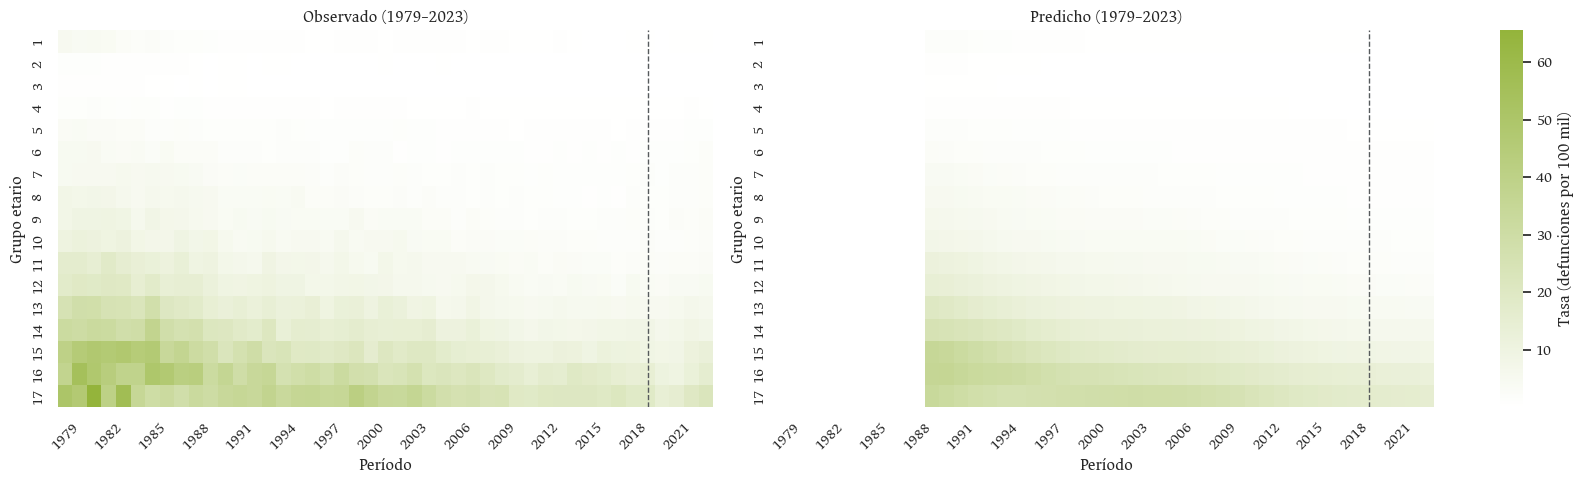

In [10]:
# Reconstrucción matrices y gráficos principales
from viz.style import get_palette, get_sequential_cmap
pal = get_palette(5)
color_obs, color_pred, color_vline = pal[0], pal[1], pal[4]

# Matrices predichas (m)
mat_train_pred = pd.pivot_table(train_df, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_val_pred = pd.pivot_table(val_df, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_obs_100k = mat * 1e5
mat_train_pred_100k = mat_train_pred * 1e5
mat_val_pred_100k = mat_val_pred * 1e5

# Averages por período
df_period_train = train_df.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})
df_period_val = val_df.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})

# Matriz completa predicha (100k) asegurando dtype float
mat_pred_full_100k = pd.DataFrame(np.nan, index=ages, columns=years, dtype=float)
train_periods = df_period_train['period'].values.astype(int)
val_periods = df_period_val['period'].values.astype(int)
mat_pred_full_100k.loc[:, train_periods] = mat_train_pred_100k.loc[:, train_periods].values.astype(float)
mat_pred_full_100k.loc[:, val_periods] = mat_val_pred_100k.loc[:, val_periods].values.astype(float)
print('dtype pred full:', mat_pred_full_100k.dtypes.unique())

# Líneas promedio por período (100k)
fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(df_period_train['period'], df_period_train['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(df_period_train['period'], df_period_train['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train'); ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (defunciones por 100 mil)'); ax[0].grid(alpha=0.3); ax[0].legend(); ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[1].plot(df_period_val['period'], df_period_val['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(df_period_val['period'], df_period_val['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación'); ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend(); ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_lineas_obs_vs_pred_100k.png'), dpi=180); plt.show()

# Heatmaps Obs vs Pred
vmin = float(min(mat_obs_100k.values.min(), mat_pred_full_100k.values.min()))
vmax = float(max(mat_obs_100k.values.max(), mat_pred_full_100k.values.max()))
cmap_seq = get_sequential_cmap(index=0)
ages_sorted = np.sort(ages)
if ages_sorted.min() == 0:
    age_labels = [f'{a*5}-{a*5+4}' if a < 16 else '80+' for a in ages_sorted]
else:
    age_labels = [f'{(a-1)*5}-{(a-1)*5+4}' if a < 17 else '80+' for a in ages_sorted]

fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0]); ax1 = fig.add_subplot(gs[0,1], sharey=ax0); cax = fig.add_subplot(gs[0,2])
sns.heatmap(mat_obs_100k, ax=ax0, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=False)
ax0.set_title('Observado (1979–2023)'); ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')
sns.heatmap(mat_pred_full_100k, ax=ax1, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cax)
ax1.set_title('Predicho (1979–2023)'); ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

tick_years = np.arange(1979, 2022, 3)
period_list = list(years)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(years == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    ax0.axvline(xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(xline, color=color_vline, ls='--', lw=1)

cax.set_ylabel('Tasa (defunciones por 100 mil)')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_matrices_obs_pred_1979_2023_100k.png'), dpi=180); plt.show()

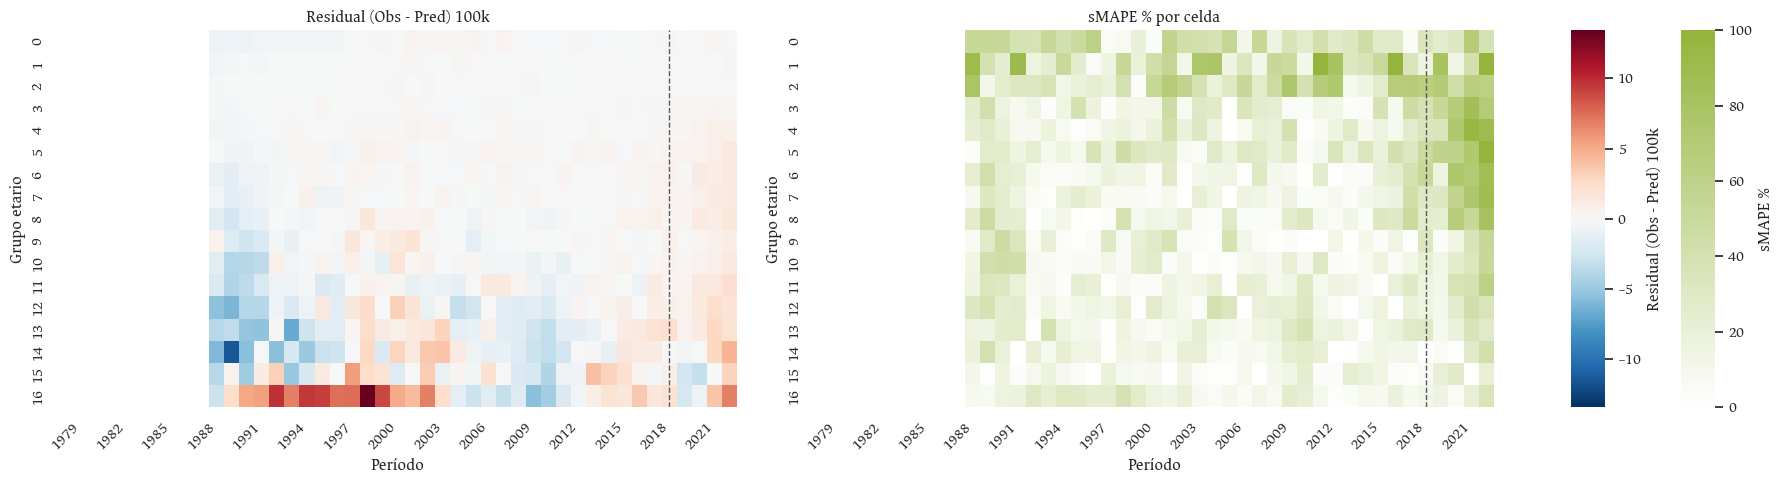

In [11]:
# Heatmaps residuales y sMAPE por celda
EPS_CELL = 1e-12
resid_100k = mat_obs_100k.values - mat_pred_full_100k.values
smape_cell = (2 * np.abs(mat_pred_full_100k.values - mat_obs_100k.values) / (np.abs(mat_pred_full_100k.values) + np.abs(mat_obs_100k.values) + EPS_CELL))*100
vmax_res = np.nanmax(np.abs(resid_100k)); vmin_res = -vmax_res
vmin_sm, vmax_sm = 0, min(100, np.nanmax(smape_cell))

cmap_seq = get_sequential_cmap(index=0)
fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1,4, width_ratios=[1,1,0.05,0.05])
ax_r = fig.add_subplot(gs[0,0]); ax_s = fig.add_subplot(gs[0,1], sharey=ax_r); cax_r = fig.add_subplot(gs[0,2]); cax_s = fig.add_subplot(gs[0,3])

sns.heatmap(resid_100k, ax=ax_r, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res, cbar=True, cbar_ax=cax_r)
ax_r.set_title('Residual (Obs - Pred) 100k'); ax_r.set_xlabel('Período'); ax_r.set_ylabel('Grupo etario')

sns.heatmap(smape_cell, ax=ax_s, cmap=cmap_seq, vmin=vmin_sm, vmax=vmax_sm, cbar=True, cbar_ax=cax_s)
ax_s.set_title('sMAPE % por celda'); ax_s.set_xlabel('Período'); ax_s.set_ylabel('Grupo etario')

tick_years = np.arange(1979, 2022, 3); period_list = list(years)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax_r, ax_s):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(years == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    for a in (ax_r, ax_s): a.axvline(xline, color=color_vline, ls='--', lw=1)

cax_r.set_ylabel('Residual (Obs - Pred) 100k')
cax_s.set_ylabel('sMAPE %')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_heatmaps_residual_smape_100k.png'), dpi=180); plt.show()

In [12]:
# Exportar matrices y formato long
mat_pred_full_m = mat_pred_full_100k / 1e5
mat_pred_full_m.index.name = 'gr_et'
mat_pred_full_100k.index.name = 'gr_et'
mat_pred_full_m.reset_index().to_csv(os.path.join(OUT_DIR,'cnn_matriz_pred_m.csv'), index=False)
mat_pred_full_100k.reset_index().to_csv(os.path.join(OUT_DIR,'cnn_matriz_pred_tasa_x100k.csv'), index=False)

# Formato long con errores (100k)
EPS_ERR = 1e-12
train_long = train_df.copy(); val_long = val_df.copy()
for d in (train_long, val_long):
    d['obs_tasa_x100k'] = d['m_obs'] * 1e5
    d['pred_tasa_x100k'] = d['m_pred'] * 1e5
    d['abs_error_100k'] = (d['pred_tasa_x100k'] - d['obs_tasa_x100k']).abs()
    d['rel_abs_error'] = d['abs_error_100k'] / (d['obs_tasa_x100k'].abs() + EPS_ERR)
train_long['dataset'] = 'train'; val_long['dataset'] = 'valid'
cols_out = ['dataset','year','age','obs_tasa_x100k','pred_tasa_x100k','abs_error_100k','rel_abs_error']
pred_long = pd.concat([train_long[cols_out], val_long[cols_out]], ignore_index=True).sort_values(['dataset','year','age']).reset_index(drop=True)
long_path = os.path.join(OUT_DIR,'cnn_predicciones_long_100k.csv')
pred_long.to_csv(long_path, index=False)
print('Exportaciones guardadas en:', OUT_DIR)
print('Long shape:', pred_long.shape)
pred_long.head()

Exportaciones guardadas en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml
Long shape: (595, 7)


,dataset,year,age,obs_tasa_x100k,pred_tasa_x100k,abs_error_100k,rel_abs_error
0,train,1989,1,1.143999,1.980301,0.836302,0.731035
1,train,1989,2,0.261641,0.693349,0.431708,1.650003
2,train,1989,3,0.202635,0.465335,0.262700,1.296424
3,train,1989,4,0.764219,0.993617,0.229398,0.300174
4,train,1989,5,1.505478,1.891008,0.385530,0.256085
